In [1]:
import Pkg
Pkg.add("Flux")
using Flux
using Flux: mse, throttle, Params, train!
using CSV
using DataFrames
using Statistics


   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


In [2]:
using CSV, DataFrames, Flux

# Load data
data = CSV.File("71-80.csv") |> DataFrame

function normalize(df::AbstractDataFrame, cols::Vector{<:AbstractString})
    means = mean.(eachcol(df[:, cols]))
    stds = std.(eachcol(df[:, cols]))

    # Convert means and stds to the appropriate shape for broadcasting
    means_matrix = repeat(means', nrow(df), 1)
    stds_matrix = repeat(stds', nrow(df), 1)

    return (df[:, cols] .- means_matrix) ./ stds_matrix
end

# Normalize data
X = normalize(data, ["cit_2017", "cit_2018", "cit_2019", "cit_2020", "cit_2021"])
Y = normalize(data, ["cit_2022"])

# Split into training and test datasets (80% train, 20% test)
n = size(data, 1)
split = floor(Int, 0.8 * n)
X_train, Y_train = X[1:split, :], Y[1:split, :]
X_test, Y_test = X[split+1:end, :], Y[split+1:end, :]


(20×5 DataFrame
 Row │ cit_2017    cit_2018    cit_2019    cit_2020    cit_2021     
     │ Float64     Float64     Float64     Float64     Float64      
─────┼──────────────────────────────────────────────────────────────
   1 │ -0.563749   -0.551538   -0.378939   -0.340915   -0.239569
   2 │ -0.541273   -0.551538   -0.555171   -0.567847   -0.640297
   3 │ -0.582138   -0.598985   -0.627622   -0.549397   -0.49995
   4 │ -0.531057   -0.54363    -0.608041   -0.610281   -0.631064
   5 │  0.0287892  -0.0276382  -0.171376   -0.104758   -0.145389
   6 │ -0.553533   -0.571307   -0.606083   -0.647181   -0.64953
   7 │ -0.60257    -0.634571   -0.666785   -0.663786   -0.703084
   8 │  4.07439     3.8077      3.62154     3.41546     3.26357
   9 │ -0.584181   -0.62864    -0.656995   -0.661941   -0.68831
  10 │  0.0757836   0.0731878  -0.0127671  -0.084463   -0.160162
  11 │ -0.375771   -0.391402   -0.418102   -0.457148   -0.45563
  12 │ -0.610743   -0.638525   -0.662869   -0.636111   -0.59413
  1

In [3]:
using Flux
using Flux: Chain, Dense, relu, mse, train!, params, ADAM


# Transpose your data to make it suitable for Flux's DataLoader
X_train = transpose(Array{Float32}(X_train))
Y_train = transpose(Array{Float32}(Y_train))
X_test = transpose(Array{Float32}(X_test))
Y_test = transpose(Array{Float32}(Y_test))

println(X_train)
println(Y_train)

model = Chain(
    Dense(5, 3, relu),
    Dense(3, 1)
)

loss(x, y) = mse(model(x), y)

# Set optimizer and learning rate
opt = ADAM(0.001)

# Define training data
data_train = Flux.Data.DataLoader((X_train, Y_train), batchsize=16)

epochs = 100
train_losses = Float64[]
test_losses = Float64[]

for epoch in 1:epochs
    for (x_batch, y_batch) in data_train
        train!(loss, params(model), [(x_batch, y_batch)], opt)
    end
    @show loss(X_train, Y_train)
        push!(train_losses, loss(X_train, Y_train))
    push!(test_losses, loss(X_test, Y_test))
end

println(size(X_train))
println(size(Y_train))

Float32[-0.39824682 -0.4799762 1.1055738 -0.52288413 -0.59439737 -0.57600826 -0.57805145 -0.0468105 0.26171792 -0.4963221 -0.60461354 1.7512358 -0.26135013 -0.6025703 -0.27973923 -0.5269706 -0.48406267 -0.58213794 5.0163245 -0.5106247 -0.5882676 -0.27565277 -0.57192177 -0.45137092 -0.14284252 0.21880998 -0.45341417 -0.5678353 0.62541366 -0.40437654 -0.5208409 0.4435658 1.2976378 0.90329355 -0.17757751 -0.41050625 -0.2899554 0.0001838911 -0.4738465 -0.48201945 1.6245553 -0.23070161 0.29645288 0.4864737 0.6764945 -0.5208409 0.16977236 -0.30425805 -0.33082008 4.812001 -0.34103626 -0.24909072 -0.17757751 -0.4738465 -0.408463 -0.4554574 -0.443198 -0.06519961 -0.17553428 -0.17962074 -0.4493277 -0.39824682 -0.15101546 1.2894648 -0.38190097 -0.48406267 -0.5555759 -0.21231249 -0.43093857 -0.43093857 -0.020248454 -0.048853736 -0.6107432 -0.29199865 1.0361037 -0.5371868 0.31892848 0.3434473 -0.5331003 -0.5187977; -0.44280383 -0.49025133 0.74338377 -0.52583694 -0.51990604 -0.58712333 -0.57723844 -

In [4]:
predictions = model(X_test)
error = mse(predictions, Y_test)

println("Test MSE: ", error)

# If you want MAE
mae = mean(abs.(predictions - Y_test))
println("Test MAE: ", mae)



Test MSE: 0.010601757
Test MAE: 0.07139168


   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


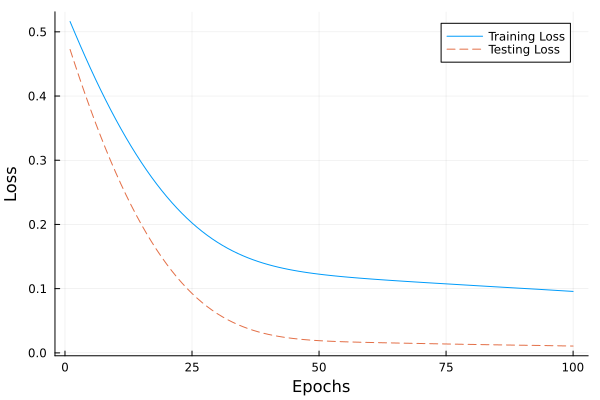

In [5]:
using Pkg
Pkg.add("Plots")

using Plots

# Plotting the losses
plot(1:epochs, train_losses, label="Training Loss", xlabel="Epochs", ylabel="Loss", line=:solid)
plot!(1:epochs, test_losses, label="Testing Loss", line=:dash)